<a href="https://colab.research.google.com/github/ShahedNaji/IntroPythonForDS/blob/master/Gibran_Exercise_DSR_Batch_30_Language_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [6]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

In [10]:
!wget https://www.gutenberg.org/cache/epub/58585/pg58585.txt

!cp pg58585.txt dataset/all 

--2022-05-06 13:01:22--  https://www.gutenberg.org/cache/epub/58585/pg58585.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89730 (88K) [text/plain]
Saving to: ‘pg58585.txt.1’

pg58585.txt.1       100%[===================>]  87.63K   231KB/s    in 0.4s    

2022-05-06 13:01:24 (231 KB/s) - ‘pg58585.txt.1’ saved [89730/89730]



In [18]:
with open("pg58585.txt") as file: 
  lines=file.readlines()
  print(len(lines))
  split_index = int(len(lines)*0.8)
  print(split_index)

  with open("dataset/train/train.txt", "w") as out_file:
    for line in lines[0:split_index]:
      out_file.write(line)


  with open("dataset/valid/valid.txt", "w") as out_file:
    for line in lines[split_index:]:
      out_file.write(line)

3469
2775


In [19]:
!ls dataset
print("")
!ls dataset/all
print("")
!ls dataset/train
print("")
!ls dataset/valid

all  train  valid

pg58585.txt

train.txt

valid.txt


In [20]:
batch_size = 32
seed = 666

def create_dataset(dataset_path):
  dataset = preprocessing.text_dataset_from_directory(
      dataset_path,
      labels=None,
      batch_size=batch_size,
      seed=seed
  )
  return dataset

dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


In [21]:
for x in dataset_original_all.take(1):
  print(x)
  

tf.Tensor([b'\xef\xbb\xbfThe Project Gutenberg eBook of The Prophet, by Kahlil Gibran\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org. If you are not located in the United States, you\r\nwill have to check the laws of the country where you are located before\r\nusing this eBook.\r\n\r\nTitle: The Prophet\r\n\r\nAuthor: Kahlil Gibran\r\n\r\nRelease Date: January 1, 2019 [eBook #58585]\r\n[Most recently updated: December 23, 2021]\r\n\r\nLanguage: English\r\n\r\n\r\nProduced by: David Widger\r\n\r\n*** START OF THE PROJECT GUTENBERG EBOOK THE PROPHET ***\r\n\r\n\r\n\r\n\r\nTHE PROPHET\r\n\r\nBy Kahlil Gibran\r\n\r\nNew York: Alfred A. Knopf\r\n\r\n1923\r\n\r\n_The Twelve Illustrations In This Volume\r\nAre Reproduced F

In [23]:
vocabulary_size = 2600

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_original_all)

vocabulary = encoder.get_vocabulary()
print(len(vocabulary), vocabulary)

2600 ['', '[UNK]', 'the', 'and', 'you', 'of', 'in', 'your', 'to', 'a', 'is', 'that', 'not', 'for', 'but', 'it', 'with', 'are', 'he', 'shall', 'his', 'i', 'or', 'be', 'have', 'project', 'when', 'who', 'all', 'this', 'if', 'would', 'work', 'as', 'from', 'which', 'my', 'gutenbergtm', 'us', 'by', 'their', 'upon', 'may', 'heart', 'said', 'love', 'they', 'on', 'what', 'yet', 'him', 'even', 'any', 'then', 'was', 'say', 'our', 'at', 'nor', 'its', 'give', 'speak', 'can', 'works', 'no', 'into', 'own', 'one', 'like', 'life', 'let', 'gutenberg', 'we', 'them', 'has', 'cannot', 'though', 'there', 'me', 'an', 'electronic', 'earth', 'do', 'other', 'only', 'must', 'unto', 'these', 'than', 'spirit', 'also', 'her', 'wind', 'soul', 'seek', 'foundation', 'answered', 'without', 'will', 'terms', 'more', 'things', 'see', 'how', 'day', 'among', 'were', 'states', 'within', 'together', 'those', 'joy', 'copyright', 'come', 'another', 'should', 'saying', 'people', 'man', 'know', 'good', 'forth', 'days', 'city', 'a

In [24]:
sequence_length = 32

def create_dataset_for_autoregression(dataset):
  x_inputs = []
  y_outputs = []

  padding_token_id = vocabulary.index("")
  assert padding_token_id == 0

  for samples in dataset: # samples == books 
    for sample in tqdm(samples): # sample == books
      sample = encoder(sample).numpy()

      padding = [padding_token_id] * sequence_length

      sample = padding + list(sample)

      for start_index in range(0, len(sample) - sequence_length):
        x = sample[start_index:start_index + sequence_length]
        assert len(x) == sequence_length
        y = sample[start_index + sequence_length]
        x_inputs += [x]
        y_outputs += [y]

  return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))

dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

print("Done.")

100%|██████████| 1/1 [00:00<00:00, 57.56it/s]


Done.


In [25]:
dataset_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(32,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [26]:
for x, y in dataset_train.take(2):
  print(x.numpy())
  print(y.numpy())
  print("")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1160

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1160]
25



Different take

In [27]:
for x, y in dataset_train.take(6):
  print(x.numpy())
  print(y.numpy())
  print("")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1160

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1160]
25

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 1160   25]
71

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1160   25   71]
156

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 1160   25   71  156]
5

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 1160
   25   71  156    5]
2



In [28]:
vocabulary[2]

'the'

Decoding

In [29]:
for input, output in dataset_train.take(16):
  #x = [for ]
  input = input.numpy()
  output = output.numpy()
  input = [vocabulary[token] for token in input if vocabulary[token] != ""]
  input = " ".join(input)
  output = vocabulary[output]

  print(input, "->", output)
  print("")

 -> ﻿the

﻿the -> project

﻿the project -> gutenberg

﻿the project gutenberg -> ebook

﻿the project gutenberg ebook -> of

﻿the project gutenberg ebook of -> the

﻿the project gutenberg ebook of the -> prophet

﻿the project gutenberg ebook of the prophet -> by

﻿the project gutenberg ebook of the prophet by -> kahlil

﻿the project gutenberg ebook of the prophet by kahlil -> gibran

﻿the project gutenberg ebook of the prophet by kahlil gibran -> this

﻿the project gutenberg ebook of the prophet by kahlil gibran this -> ebook

﻿the project gutenberg ebook of the prophet by kahlil gibran this ebook -> is

﻿the project gutenberg ebook of the prophet by kahlil gibran this ebook is -> for

﻿the project gutenberg ebook of the prophet by kahlil gibran this ebook is for -> the

﻿the project gutenberg ebook of the prophet by kahlil gibran this ebook is for the -> use



In [30]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

Epoch 1/10
23/23 [==============================] - 18s 476ms/step - loss: 6.4813 - accuracy: 0.0512 - val_loss: 7.0316 - val_accuracy: 0.0601
Epoch 2/10
23/23 [==============================] - 10s 436ms/step - loss: 5.9007 - accuracy: 0.0673 - val_loss: 7.2056 - val_accuracy: 0.0346
Epoch 3/10
23/23 [==============================] - 10s 437ms/step - loss: 5.8645 - accuracy: 0.0633 - val_loss: 7.3167 - val_accuracy: 0.0601
Epoch 4/10
23/23 [==============================] - 10s 438ms/step - loss: 5.8978 - accuracy: 0.0627 - val_loss: 7.4193 - val_accuracy: 0.0565
Epoch 5/10
23/23 [==============================] - 10s 441ms/step - loss: 5.8625 - accuracy: 0.0615 - val_loss: 7.4890 - val_accuracy: 0.0601
Epoch 6/10
23/23 [==============================] - 10s 442ms/step - loss: 5.7902 - accuracy: 0.0697 - val_loss: 7.3961 - val_accuracy: 0.0464
Epoch 7/10
23/23 [==============================] - 10s 442ms/step - loss: 5.7285 - accuracy: 0.0731 - val_loss: 7.4832 - val_accuracy: 0.0678

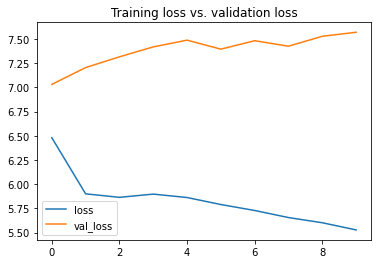

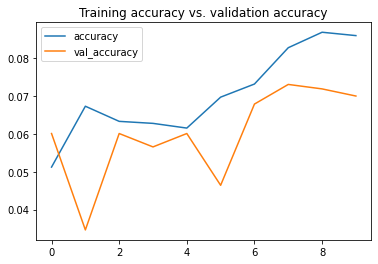

In [31]:
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(512, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(1024))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(vocabulary_size, activation="softmax"))
model.summary

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(10_000).batch(512),
    epochs=10,
    validation_data=dataset_valid.cache().batch(512)
)

render_history(history)

In [32]:
import numpy as np

def decode(indices):
    return " ".join([vocabulary[index] for index in indices if vocabulary[index] is not ""])
    
def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0))
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")

        
def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)
  

generate(model, "we are all doomed", 100, temperature=1.0)

we are all [UNK] the unbeautiful and but a honour and the solver that the reuse of he this gratitude his sunlight of its a ether the shame and in a dark wrongdoer and his seen all speaks in not heart love seeds too as unto vineyards said and fastened selfchosen for the living the “i even located to love am murdered to sandtowers of it song watchmen when would ship and they little ox earth the her serve him old fulfilment and have voice located you understand heart upon so love his world of to you we the mirrored

